### <center> Pneumonia/Lung Disease Prediction/Classification Using Image Data Generator </center>

<b> Problem Statement</b>: In this project we have chest x-ray images of patients with lung disease(pneumonia) and those which do not have lung disease(normal).The aim is to build a convulutional neural network(CNN) model to predict or classify the images into the aforementioned classes and test our model with live data. This model will be served with a Rest API developed in python's FastAPI. Then, React Js and React Native clients will also be developed to consume the API. The dataset utilized in this project can be downloaded here: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia?resource=download


An Otsogile Ogaisitse Onalepelo aka Morena Project

### Import all the Dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import models, layers
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report,confusion_matrix,roc_curve, auc
import cv2
import os

In [2]:
labels = ['PNEUMONIA', 'NORMAL'] #We have two classes: NORMAL and PNEUMONIA present in our dataset
img_size = 150 #set the size we want for all images: 150*150

def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshape images to our preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data,dtype=object)

### Load The Data

Fortunately our dataset is already divided into train, validation and test sets. All we have to do is load it with the custom function we wrote above.

In [3]:
train = get_data('./dataset/chest_xray/train')
test = get_data('./dataset/chest_xray/test')
val = get_data('./dataset/chest_xray/val')

Split the features from the labels

In [4]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

### Normalize The Data
To improve model performance, we should normalize the image pixel values (keeping them in range 0 and 1 by dividing by 255). RGB values range from 0 to 255 hence we are dividing by 255. 

In [5]:
# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

### Resize The Data

Before we feed our images to a network, we should resize them to the desired size.

In [39]:
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

#### Data Augmentation

Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data and it also helps curb overffiting.The reason is that, as we add more data, the model is unable to overfit all the samples, and is forced to generalize.

In [7]:
datagen = ImageDataGenerator(
        featurewise_center=False,            # set input mean to 0 over the dataset
        samplewise_center=False,             # set each sample mean to 0
        featurewise_std_normalization=False, # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,                 # apply ZCA whitening
        rotation_range = 30,                 # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2,                    # Randomly zoom image 
        width_shift_range=0.1,               # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,              # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,              # randomly flip images
        vertical_flip=False                  # randomly flip images
)  

datagen.fit(x_train)

### Model Architecture

We use a CNN coupled with a Sigmoid activation function in the output layer. In between we have regularization, pooling, within layer normalization and relu activation function.

In [8]:
model = models.Sequential([
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', strides = 1, padding = 'same', input_shape=(150,150,1)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2), strides = 2, padding = 'same'),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu', strides = 1, padding = 'same'),
    layers.Dropout(0.1),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2),strides = 2),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu',strides = 1, padding = 'same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2), strides = 2),
    layers.Conv2D(128, (3, 3), activation='relu', strides = 1, padding = 'same'),
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2), strides = 2),
    layers.Conv2D(256, (3, 3), activation='relu', strides = 1, padding = 'same'),
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2),strides = 2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid'),
])

model.build(input_shape=(150,150,1))

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 150, 150, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 75, 75, 64)       2

### Model Callbacks

In [10]:
#learning rate callback
reduce_lr_callback =  tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.3,
    patience=1,
    verbose=1,
    min_lr=0.000001
)

#early stoping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=15,
    verbose=1
)

#checkpoint callback
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    'pneumonia_prediction_best_model_v2.h5',
    monitor='val_accuracy',
    verbose=1,
    mode='max',
    save_best_only=True)

model_callbacks = [early_stopping_callback,reduce_lr_callback,checkpoint_callback]

In [11]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

In [12]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 50 , validation_data = datagen.flow(x_val, y_val) ,callbacks = [model_callbacks])

Epoch 1/50
163/163 [==============================] - ETA: 0s - loss: 0.3605 - accuracy: 0.8646
Epoch 00001: val_accuracy improved from -inf to 0.50000, saving model to pneumonia_prediction_best_model_v2.h5
163/163 [==============================] - 454s 3s/step - loss: 0.3605 - accuracy: 0.8646 - val_loss: 11.9648 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/50
163/163 [==============================] - ETA: 0s - loss: 0.2212 - accuracy: 0.9118
Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.

Epoch 00002: val_accuracy did not improve from 0.50000
163/163 [==============================] - 450s 3s/step - loss: 0.2212 - accuracy: 0.9118 - val_loss: 9.4334 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/50
163/163 [==============================] - ETA: 0s - loss: 0.1675 - accuracy: 0.9385
Epoch 00003: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.

Epoch 00003: val_accuracy did not improve from 0.50000
163/163 [=============================

In [13]:
# load the saved model
saved_model = load_model('pneumonia_prediction_best_model_v2.h5')

In [14]:
scores = saved_model.evaluate(x_test,y_test)

20/20 [==============================] - 14s 669ms/step - loss: 0.2444 - accuracy: 0.9071


In [15]:
history

In [16]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 163}

In [17]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

In [18]:
type(history.history['loss'])

list

In [19]:
len(history.history['loss'])

22

In [20]:
#show loss for first 5 epochs
history.history['loss'][:5] 

[0.3604659140110016,
 0.22115658223628998,
 0.16749319434165955,
 0.1446351408958435,
 0.14385361969470978]

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [22]:
acc

[0.8646472096443176,
 0.9118098020553589,
 0.9384585618972778,
 0.9468941688537598,
 0.9467024803161621,
 0.9547545909881592,
 0.9491947889328003,
 0.9534125924110413,
 0.9503450989723206,
 0.9505367875099182,
 0.9534125924110413,
 0.9534125924110413,
 0.9499616622924805,
 0.9514954090118408,
 0.9509202241897583,
 0.9474693536758423,
 0.9518788456916809,
 0.9513036608695984,
 0.9555214643478394,
 0.9499616622924805,
 0.9501533508300781,
 0.9532208442687988]

In [23]:
val_acc

[0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.625,
 0.5625,
 0.625,
 0.625,
 0.625,
 0.5625,
 0.6875,
 0.5625,
 0.5625,
 0.5625,
 0.6875,
 0.5625,
 0.5625,
 0.5625,
 0.5625,
 0.5,
 0.625]

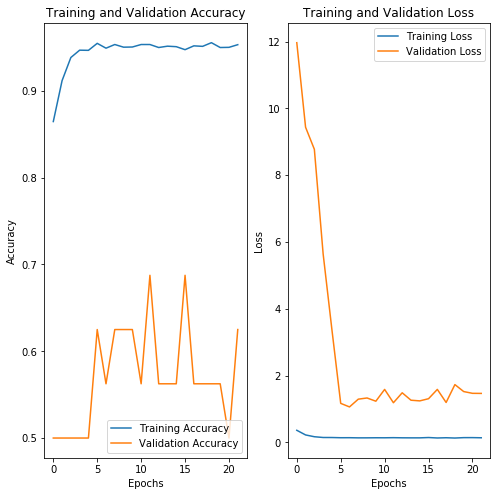

In [25]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(22), acc, label='Training Accuracy')
plt.plot(range(22), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy")
plt.xlabel("Epochs")

plt.subplot(1, 2, 2)
plt.plot(range(22), loss, label='Training Loss')
plt.plot(range(22), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.show()

In [26]:
predictions = saved_model.predict(x_test)
predictions = predictions.reshape(1,-1)[0]
predictions[:15]

array([3.1770054e-01, 5.1318496e-02, 9.9521349e-05, 2.2503734e-04,
       6.4623356e-04, 4.6044588e-04, 8.9278817e-04, 4.0255036e-05,
       3.5430813e-01, 2.6427805e-03, 6.7269802e-04, 1.1058083e-01,
       7.4290721e-05, 2.3743808e-03, 8.6719930e-02], dtype=float32)

In [27]:
predictions = predictions.round()
predictions

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [28]:
y_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

### Model Performance Evaluation


#### Classification Report

In [30]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.92      0.94      0.93       390
   Normal (Class 1)       0.89      0.86      0.87       234

           accuracy                           0.91       624
          macro avg       0.90      0.90      0.90       624
       weighted avg       0.91      0.91      0.91       624



#### Confusion Matrix

In [31]:
cm = confusion_matrix(y_test,predictions)
cm

array([[365,  25],
       [ 33, 201]], dtype=int64)

In [32]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

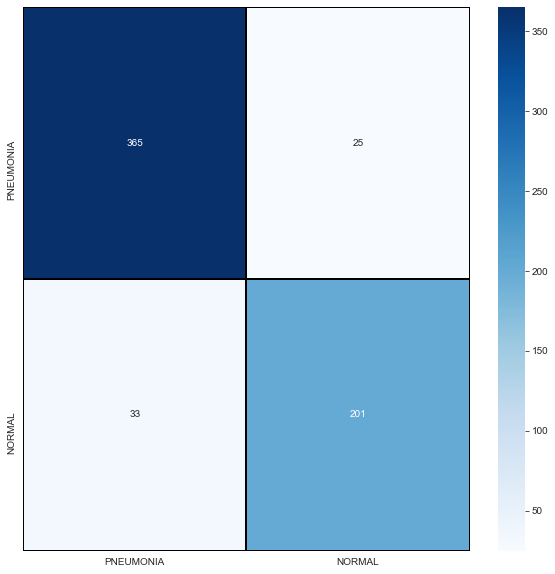

In [33]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

Of the 390 total pneumoninia images, our model classified 365 correctly and made 25 classifications. It only made 33 misclassifications from a total of 234 normal patients and correctly classified 201 images.

#### ROC & AUC Graph

In [34]:
#calculate the false positive rate and true positive rate
fpr, tpr, _ = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)

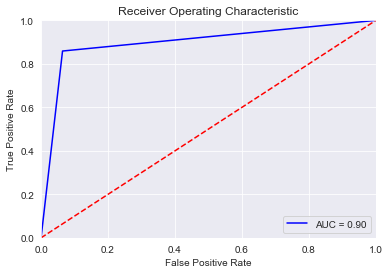

In [35]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Model Performance Remarks

As opposed to our previous model which we utilized tf.data API, this model using image data generator is performing much better. It is actually doing a stellar job identifying patients with pneumonia evidenced by the class 0 recall and f1 scores from the classification report and the AUC score. Even though we have a class imbalance and therefore cannot really rely on the accuracy score. It is not very bad at 91%. Therefore, this is the model version we will used to make inferences from the mobile and web apps.

In [36]:
#Divide predictions made into correct and incorrect
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

### Display Correctly Predicted Classes

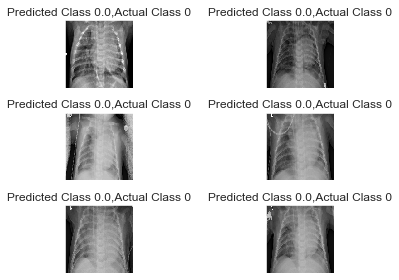

In [40]:
#get the first 6 correct predictions
i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

### Display Incorrectly Predicted Classes

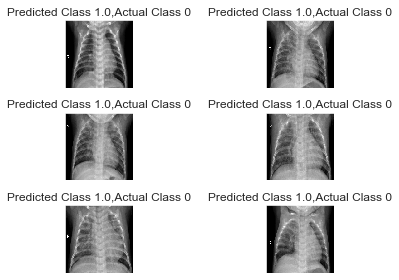

In [38]:
#get the first 6 incorrect predictions
i = 0
for c in incorrect[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

### Export / Save The Final Model

In [ ]:
model.save("./pneumonia_prediction_final_model_v2.h5")

In [42]:
x_train[0]

array([[[0.07058824],
        [0.10980392],
        [0.11372549],
        ...,
        [0.05098039],
        [0.02745098],
        [0.00392157]],

       [[0.08235294],
        [0.09411765],
        [0.11372549],
        ...,
        [0.05490196],
        [0.03529412],
        [0.01176471]],

       [[0.08627451],
        [0.10196078],
        [0.1254902 ],
        ...,
        [0.0627451 ],
        [0.03529412],
        [0.00784314]],

       ...,

       [[0.03921569],
        [0.03529412],
        [0.03137255],
        ...,
        [0.05882353],
        [0.05882353],
        [0.05882353]],

       [[0.03921569],
        [0.03921569],
        [0.03137255],
        ...,
        [0.05882353],
        [0.05882353],
        [0.05882353]],

       [[0.03921569],
        [0.03921569],
        [0.03137255],
        ...,
        [0.05882353],
        [0.05882353],
        [0.05882353]]])